In [1]:
import numpy as np
import pandas as pd
import glob
import musclebeachtools as mbt
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import samb_work.dimtools as dimt
from scipy.stats import ranksums
from scipy.stats import kstest
from datetime import date
import sys
import json

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

basedir = '/hlabhome/sbrunwa/git/appps1'
pth = f'{basedir}/notebooks/figure_1/'

In [3]:
#                        Colors

with open(f'{basedir}/colormaps/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)
    
with open(f'{basedir}/colormaps/reg_colors.json') as json_file:
    reg_clrs = json.load(json_file)

dump = 0

In [4]:
def bonfcorr(pvals):
    
    from statsmodels.stats.multitest import multipletests as bonferonni

    #bonferroni correction for multiple comparisons
    pvals_bonf = bonferonni(pvals)[1]
    
    return pvals_bonf

def get_signif(pvals):
    pval_labs = np.zeros(len(pvals),dtype='object')

    pval_labs[pvals > 0.05] = ''
    pval_labs[pvals < 0.05] = '*'
    pval_labs[pvals < 0.005] = '**'
    pval_labs[pvals < 0.0001] = '***'

    pval_labs = pval_labs.tolist()
    
    return pval_labs

def nrnlistinfo(nrnlist):
	'''
	Prints basic info about a list of neuron objects, including number of neurons in the list and length of recording.
	Prints information about animal, region, condition if available.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	'''
	import numpy as np
	import musclebeachtools as mbt

	neurons = np.array(nrnlist)
	nrncount = neurons.shape[0]
	print('There are ' + '\033[1m' + str(nrncount) + ' neurons \033[0m in this file.' )
	maxtimes = np.zeros(nrncount)
	for i, cell in enumerate(neurons):
	    maxtimes[i] = np.max(cell.spike_time)/(cell.fs*3600)

	reclength = np.round(np.mean(maxtimes),2)
	print('Recording is \033[1m ' + str(reclength) + ' hours \033[0m long. ')

	#add print statement for number of animals in nrnlist
	if hasattr(neurons[0],'animal'):
		print('These neurons are from the following animal(s):')
		print(np.unique([n.animal for n in neurons]))

	#add print statement for number of region in nrnlist
	if hasattr(neurons[0],'region'):
		print('These neurons are in the following region(s):')
		print(np.unique([n.region for n in neurons]))

	#add print statement for number of conditions in nrnlist
	if hasattr(neurons[0],'condition'):
		print('These neurons are under the following conditions(s):')
		print(np.unique([n.condition for n in neurons]))

def nrnlist_by_quality(nrnlist,quals=[1]):
    '''
    Filter list of neuron objects to only select neurons from a defined quality.

    Inputs:
    nrnlist - list of mbt.neuron class objects
    quals - list - [1] for only quality 1 cells, [1,2] for quality 1 and 2 cells, etc

    Returns:
    n_filtered - filtered list of mbt.neuron class objects matching input criteria

    '''
    import numpy as np
    import musclebeachtools as mbt

    if hasattr(nrnlist[0],'quality'):
        n_filtered = []
        for n in nrnlist:
            if (n.quality in quals):
                n_filtered.append(n)
        return(n_filtered)
    else:
        print("Neurons don't have quality attribute.")

def nrnlist_by_animal(nrnlist,animal):
	'''
	Filter list of neuron objects to only select neurons from a defined animal.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	animal - str - name of animal to select neurons from, e.g. 'CAF69'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'animal'):
		n_filtered = []
		for n in nrnlist:
		    if n.animal == animal:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have animal attribute.")

def nrnlist_by_region(nrnlist,region):
	'''
	Filter list of neuron objects to only select neurons from a defined region.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	region - str - name of region to select neurons from, e.g. 'V1'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'region'):
		n_filtered = []
		for n in nrnlist:
		    if n.region == region:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have region attribute.")


def nrnlist_by_condition(nrnlist,condition):
	'''
	Filter list of neuron objects to only select neurons from a defined condition.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	condition - str - name of animal to select neurons from, e.g. 'WT'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'condition'):
		n_filtered = []
		for n in nrnlist:
		    if n.condition == condition:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have condition attribute.")

def nrnlist_by_celltype(nrnlist,celltype):
	'''
	Filter list of neuron objects to only select neurons from a defined cell type.

	Inputs:
	nrnlist - list of mbt.neuron class objects
	celltype - str - name of celltype, e.g. 'RSU' or 'FS'

	Returns:
	n_filtered - filtered list of mbt.neuron class objects matching input criteria

	'''
	import numpy as np
	import musclebeachtools as mbt

	if hasattr(nrnlist[0],'cell_type'):
		n_filtered = []
		for n in nrnlist:
		    if n.cell_type == celltype:
		        n_filtered.append(n)
		return(n_filtered)
	else:
		print("Neurons don't have condition attribute.")

def nrnlist_by_genotype(nrnlist,genotype='WT'):
    '''
    Filter list of neuron objects to only select neurons from a defined quality.

    Inputs:
    nrnlist - list of mbt.neuron class objects
    genotype - str - name of genotype desired

    Returns:
    n_filtered - filtered list of mbt.neuron class objects matching input criteria

    '''
    import numpy as np
    import musclebeachtools as mbt
    
    n_filtered = []
    
    if genotype in ['WT','wt','wildtype']:
        genos = ['WT','wt','wildtype']
    elif genotype in ['APP','app','app_ps1','APP/PS1','appps1']:
        genos = ['APP','app','app_ps1','APP/PS1','appps1']
        
    for n in nrnlist:
        if hasattr(n,'condition'):
            if n.condition in genos:
                n.genotype = genotype
                n_filtered.append(n)
        elif hasattr(n,'genotype'):
            if n.genotype in genos:
                n.genotype = genotype
                n_filtered.append(n)
        elif hasattr(n,'geno'):
            if n.geno in genos:
                n.genotype = genotype
                n_filtered.append(n)
        else:
            print(f'Neuron {n+1} is missing genotype attribute.')
    return(n_filtered)

def smooth_1darray(onedarray,binsize,sigma):
	'''
	onedarray - np.array - 1d array of binned data
	binsize - size of bins in onedarray (in seconds)
	sigma - width of gaussian kernel for smoothing (in seconds) e.g. 0.05 is a typical sigma (50 ms)
	'''

	from scipy.ndimage import gaussian_filter

	#smoothing using code copied from https://matthew-brett.github.io/teaching/smoothing_intro.html
	sig = sigma/binsize
	array_smoothed = gaussian_filter(onedarray, sigma=sig)

	return(array_smoothed)

In [5]:
#Set the variables and directories

binsize = 0.1 #0.01 #in seconds
smoothed = 0

animallist = ['CAF69','CAF71','CAF73','CAF74','CAF75','CAF77','CAF81','CAF82']
datelist = ['1228','0103','0120','0125','0125','0202','0304','0304']
epochlist = ['0_12','0_12','4_15','60_72','65_76','12_24','0_12','0_12']
condlist = ['WT','APP','APP','APP','APP','WT','WT','WT']

nrnfiles = []
for i in range(len(animallist)):
    nrnfiles.append(f'{basedir}/data/{animallist[i]}/{datelist[i]}/{epochlist[i]}/{animallist[i]}_{datelist[i]}_{epochlist[i]}_singleunits.npy')

nrns = np.array([])
for nrnf in nrnfiles:
    nrns = np.append(nrns,np.load(nrnf,allow_pickle=True))
    
n_wt_all = nrnlist_by_genotype(nrns,'WT')
n_app_all = nrnlist_by_genotype(nrns,'APP')

n_wt = nrnlist_by_quality(n_wt_all,[1,2])
n_app = nrnlist_by_quality(n_app_all,[1,2])

<h1>Panel A: Unit waveforms across genotype</h1>

In [6]:
regions = ['RSC','ACC','V1']

colnames=['animal','geno','region','nrn_id','clust_idx','peaklat','wf_dur','wf_amp','presrat']
nrnarray = np.zeros([len(n_wt)+len(n_app),len(colnames)])
nrndf = pd.DataFrame(nrnarray,columns = colnames)
dfind = 0

for animal in animallist:

    a = animallist.index(animal)
    date = datelist[a]
    epoch = epochlist[a]
    cond = condlist[a]

    if cond == 'WT':
        n_animal = dimt.nrnlist_by_animal(n_wt,animal)
    elif cond == 'APP':
        n_animal = dimt.nrnlist_by_animal(n_app,animal)

    for r,reg in enumerate(regions):
        nrnlist_reg = dimt.nrnlist_by_region(n_animal,reg)
        for nrn_id,nrn in enumerate(nrnlist_reg):
            clustidx = nrn.clust_idx
            peaklat = nrn.peaklatency
            wf_dur = (np.argmax(nrn.waveform) - np.argmin(nrn.waveform)) * (1e3/nrn.fs)
            wf_amp = nrn.mean_amplitude
            presrat = nrn.presence_ratio()
            nrndf.iloc[dfind] = [animal,cond,reg,nrn_id,clustidx,peaklat,wf_dur,wf_amp,presrat]
            dfind += 1
            
nrndf = nrndf.loc[~(nrndf==0).all(axis=1)]

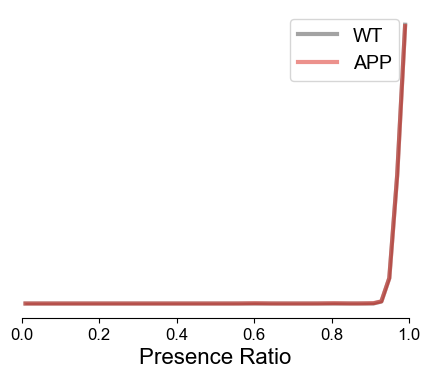

In [7]:
hists_wt = np.zeros([4,49])
hists_app = np.zeros([4,49])
wtlist = np.unique(nrndf[nrndf.geno=='WT'].animal)
applist = np.unique(nrndf[nrndf.geno=='APP'].animal)

a = 0
b = 0
for anim in animallist:
    counts, bins =  np.histogram(nrndf[nrndf.animal == anim].presrat,bins=np.linspace(0,1,50),density=True)
    x = bins[:-1] + bins[1]/2
    if anim in wtlist:
        hists_wt[a,:] = smooth_1darray(counts,1,1)
        a += 1
    elif anim in applist:
        hists_app[b,:] = smooth_1darray(counts,1,1)
        b += 1
        
fig, ax = plt.subplots(figsize=(5, 4))
meanwt = np.mean(hists_wt,axis=0)
semwt = np.std(hists_wt,axis=0)
meanapp = np.mean(hists_app,axis=0)
semapp = np.std(hists_app,axis=0)
ax.plot(x,meanwt,color=geno_clrs['WT'],alpha=0.5,linewidth=3,label='WT')
ax.plot(x,meanapp,color=geno_clrs['APP'],alpha=0.5,linewidth=3,label='APP')
ax.fill_between(x,meanwt-semwt,meanwt+semwt,color=geno_clrs['WT'],alpha=0.2)
ax.fill_between(x,meanapp-semapp,meanapp+semapp,color=geno_clrs['APP'],alpha=0.2)

ax.set_xlabel('Presence Ratio',fontsize = 16)

plt.xticks(fontsize=12)
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# stat_stat, stat_p = kstest(nrndf[nrndf.geno == 'WT'].presrat.values,nrndf[nrndf.geno == 'APP'].presrat.values)
# ax.text(0.2,10, f"ks test: stat={np.round(stat_stat,3)}, p={np.round(stat_p,3)}")

plt.xlim(0,1)
plt.legend(fontsize=14)
if dump:
    filename = 'presrat_by_geno.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()

<h1>Panel B: Unit yield across region and genotype</h1>

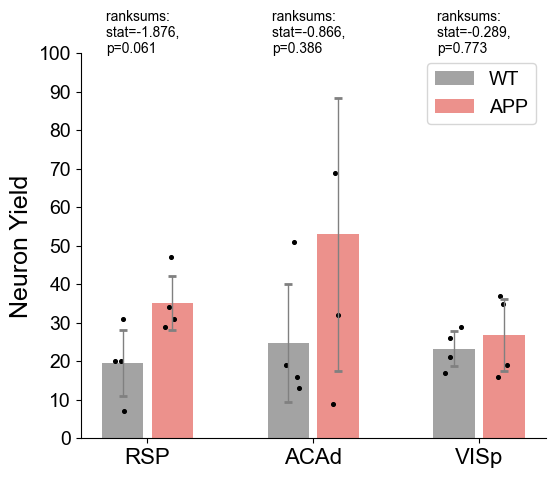

In [9]:
regions = ['RSC','ACC','V1']

colnames=['animal','geno','region','nrn_count','rsu_count','fs_count']
nrnarray = np.zeros([len(animallist)*len(regions),len(colnames)])
nrndf = pd.DataFrame(nrnarray,columns = colnames)
dfind = 0

for animal in animallist:

    a = animallist.index(animal)
    date = datelist[a]
    epoch = epochlist[a]
    cond = condlist[a]

    if cond == 'WT':
        n_animal = nrnlist_by_animal(n_wt,animal)
    elif cond == 'APP':
        n_animal = nrnlist_by_animal(n_app,animal)

    for r,reg in enumerate(regions):
        nrnlist_reg = dimt.nrnlist_by_region(n_animal,reg)
        nrn_count = len(nrnlist_reg)
        rsu_count = len(nrnlist_by_celltype(nrnlist_reg,'RSU'))
        fs_count = len(nrnlist_by_celltype(nrnlist_reg,'FS'))
        nrndf.iloc[dfind] = [animal,cond,reg,nrn_count,rsu_count,fs_count]
        dfind += 1

regions = ['RSC','ACC','V1']
uniqcond = np.array(['WT','APP'])

peak_mean = np.zeros(len(regions)*2)
peak_sem = np.zeros(len(regions)*2)
count = 0
#for every condition and comparison, i.e. bar in the barplot
for reg in regions:
    for cond in uniqcond:
        bar_cond = cond
        n_animals = len(np.unique(nrndf[nrndf.geno==bar_cond].animal))
        bar_peaks = nrndf[(nrndf.geno==bar_cond)&(nrndf.region==reg)].nrn_count.values
        if np.sum(np.isnan(bar_peaks)) > 0:
            print('found nans')
#         bar_sem = np.nanstd(bar_peaks) / n_animals
        bar_sem = np.nanstd(bar_peaks)
        peak_mean[count] = np.nanmean(bar_peaks)
        peak_sem[count] = bar_sem
        count += 1

###PLOT
fig, ax = plt.subplots(figsize=(6, 5))
xpos = 0

for i,comp in enumerate(regions):
    for j,cond in enumerate(uniqcond):
        if j == 0:
            xfudge = 0.2
        elif j == 1:
            xfudge = -0.2

        ax.bar(xpos + xfudge,peak_mean[xpos],yerr = peak_sem[xpos],
               color = geno_clrs[cond],alpha=0.5, align='center', width=0.5,
               error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=2))

        plt_pts = nrndf[(nrndf.geno==cond)&(nrndf.region==comp)].nrn_count.values
        plt_pts = plt_pts[~np.isnan(plt_pts)]

        jitter = np.random.randn(len(plt_pts)) / 15
        ax.scatter(np.tile(xpos + xfudge,len(plt_pts))+jitter,
                    plt_pts,s=7,c='black',alpha=1,label='_nolegend_')
        xpos += 1

    stat_stat, stat_p = ranksums(nrndf[(nrndf.geno=='WT')&(nrndf.region==comp)].nrn_count.values,
                                 nrndf[(nrndf.geno=='APP')&(nrndf.region==comp)].nrn_count.values)
    ax.text(xpos-2,100, f"ranksums: \nstat={np.round(stat_stat,3)}, \np={np.round(stat_p,3)}")


xtickpos = np.arange(0,len(regions)*2,2)
ax.set_ylabel('Neuron Yield',fontsize = 18)
ax.set_xlabel('')
ax.get_xaxis().set_ticks(xtickpos+0.5)
ax.get_xaxis().set_ticklabels(['RSP','ACAd','VISp'],fontsize=16)
ytickpos = np.arange(0,101,10)
ax.get_yaxis().set_ticks(ytickpos)
ax.get_yaxis().set_ticklabels(ytickpos,fontsize=14)
ax.set_ylim(0,100)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['WT','APP'],fontsize=14)

filename = 'nrnyield_by_geno.pdf'

if dump:
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()